In [1]:
import numpy as np
import extq
import ivac
import pyemma
import glob
import sys
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
sys.path.insert(1, "../python")
sys.path.insert(1, "../..")
import util
import kde

In [3]:
import seaborn as sns

plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load feature 2 data (salt bridges)

In [4]:
with np.load("../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [5]:
print(len(data))
print(data[0].shape)

1295
(3000, 60)


In [6]:
data_arr = np.concatenate(data)
print(data_arr.shape)

(6580000, 60)


## load CVs 

In [7]:
with np.load("../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cv_arr = f["arr_0"]

In [8]:
traj_lens = [len(traj) for traj in data]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)
cv_trajs = np.split(cv_arr, traj_inds)

In [9]:
cv_arr.shape

(6580000, 2)

In [10]:
# take only last 30 features (Cz - Cd distances)
data_cz = [traj[:, 30:] for traj in data]

## Models 

In [11]:
feat2_models = np.load("../data/models_feat2.npy")

In [12]:
models_cz = feat2_models[:, 30:]

# IVAC with indicators

## binary distance cutoff at 4.5 Angstroms

In [13]:
data_cz_ind45 = [np.where(traj < 4.5, 1, 0) for traj in data_cz]

In [14]:
ivac_ind45 = ivac.LinearIVAC(
    minlag=1,
    maxlag=1000,
    nevecs=5,
    addones=False,
    reweight=False,
    adjust=True,
    method="fft",
)
ivac_ind45.fit(data_cz_ind45)
data_ivac_ind45 = ivac_ind45.transform(data_cz_ind45)

LinAlgError: The leading minor of order 2 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

5.0 Angstroms

In [15]:
data_cz_ind5 = [np.where(traj < 5, 1, 0) for traj in data_cz]
ivac_ind5 = ivac.LinearIVAC(
    minlag=1,
    maxlag=3000,
    nevecs=5,
    addones=False,
    reweight=False,
    adjust=True,
    method="fft",
)
ivac_ind5.fit(data_cz_ind5)

LinAlgError: The leading minor of order 2 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [16]:
data_cz_ind5 = [np.where(traj < 5, 1, 0) for traj in data_cz]
ivac_ind5 = ivac.LinearIVAC(
    minlag=1,
    maxlag=1000,
    nevecs=5,
    addones=False,
    reweight=False,
    adjust=True,
    method="fft",
)
ivac_ind5.fit(data_cz_ind5)

LinAlgError: The leading minor of order 2 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

## rational switching function for indicator, cutoff at 4.5 Angstroms

In [55]:
# changed rational switch to use d0 as parameter (increases distance where turns on)

In [74]:
def rat_switch(r, r0, d0):
    ratio = (r - d0) / r0
    return (1 - ratio ** 6) / (1 - ratio ** 12)

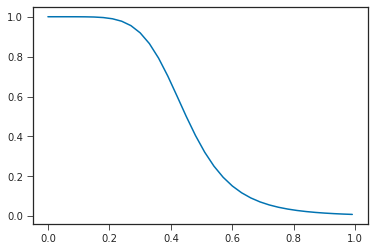

In [76]:
x = np.arange(0, 1, 0.03)
plt.plot(x, rat_switch(x, 0.45, 0))

In [77]:
r0 = 0.45  # nanometers
d0 = 0
data_indswitch = [rat_switch(traj, r0, d0) for traj in data_cz]

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
ivac_switch45 = ivac.LinearIVAC(
    minlag=1, maxlag=3000, nevecs=5, reweight=False, adjust=True, method="fft"
)
ivac_switch45.fit(data_indswitch)
data_ivac_switch45 = ivac_switch45.transform(data_indswitch)

ValueError: array must not contain infs or NaNs

4.26.21: there was an error in the previous code

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac_switch45.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac_switch45.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([1000, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

In [ ]:
for i in range(1, 4):
    plt.plot(ivac_switch45.evecs[i], ".-", label=f"iTIC {i}")
plt.xlim([0, 29])
plt.legend()

In [ ]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.plot(ivac_switch45.evecs[i + 1], ".-")
    ax.set_xlim([0, 30])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_title(f"iTIC {i+1}")

In [46]:
data_ivac_switch = np.concatenate(data_ivac_switch45)
models_switch = rat_switch(models_cz, 4.5)
models_ivac_switch = ivac_switch45.transform([models_switch])[0]

In [48]:
models_switch

array([[0.84015614, 0.7284038 , 0.8145478 , 0.9836733 , 0.9950822 ,
        0.97254145, 0.8004987 , 0.97072774, 0.97250897, 0.72094965,
        0.8059513 , 0.6432102 , 0.95333934, 0.99674666, 0.99784327,
        0.8846962 , 0.6837741 , 0.6990929 , 0.98975   , 0.99954104,
        0.9998789 , 0.97954965, 0.898326  , 0.9095397 , 0.9965355 ,
        0.99992204, 0.9999932 , 0.99216586, 0.9648884 , 0.9716619 ],
       [0.9619206 , 0.9248569 , 0.9418136 , 0.9979998 , 0.99762607,
        0.9876021 , 0.6614052 , 0.82005924, 0.843494  , 0.9297265 ,
        0.95776486, 0.884597  , 0.7400212 , 0.9370433 , 0.9354528 ,
        0.82621   , 0.86166716, 0.7263524 , 0.9624124 , 0.9949388 ,
        0.99714166, 0.9613741 , 0.8488754 , 0.80180526, 0.9828568 ,
        0.9984152 , 0.99941814, 0.97968155, 0.90420353, 0.89410746],
       [0.9888645 , 0.9794359 , 0.9843693 , 0.99922246, 0.9992583 ,
        0.9951768 , 0.8453139 , 0.70705783, 0.8076352 , 0.985778  ,
        0.9951198 , 0.97698814, 0.6488481 , 0.

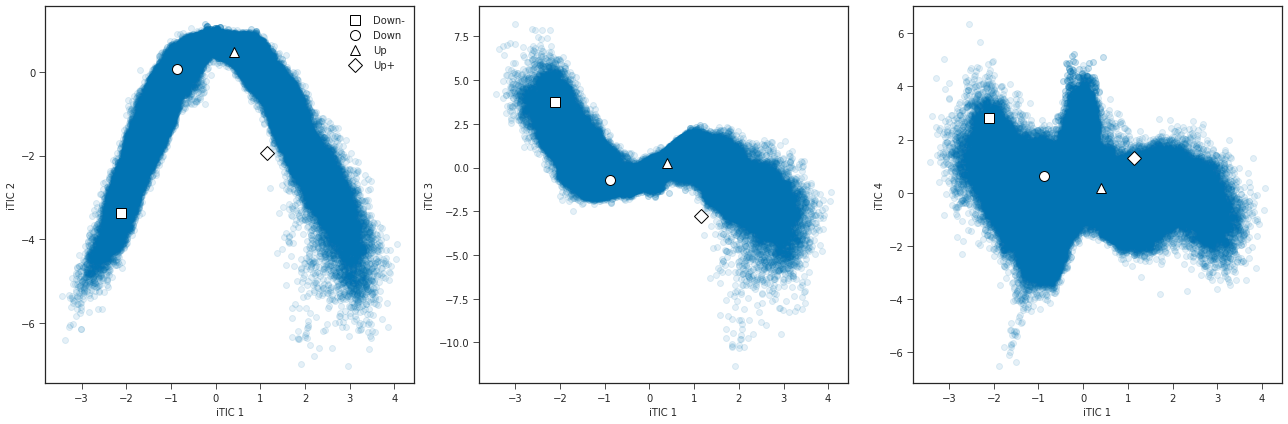

In [32]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(data_ivac_switch[::10, 1], data_ivac_switch[::10, i + 2], alpha=0.1)
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_ivac_switch[:, 1:3])
util.plot_models(axs[1], models_ivac_switch[:, 1:4:2])
util.plot_models(axs[2], models_ivac_switch[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

## Tanh switching function 

In [90]:
def tanh_switch(r, r0, d0):
    return 1 - np.tanh((r - d0) / r0)

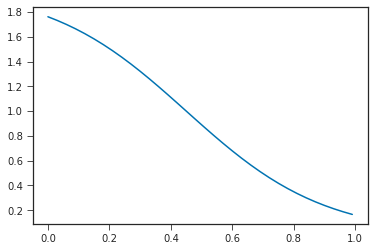

In [91]:
x = np.arange(0, 1, 0.03)
plt.plot(x, tanh_switch(x, 0.45, 0.45))

## Gaussian switching function 

In [96]:
def gauss_switch(r, r0, d0):
    return np.where(r < d0, 1, np.exp(-((r - d0) ** 2) / (2 * r0 ** 2)))

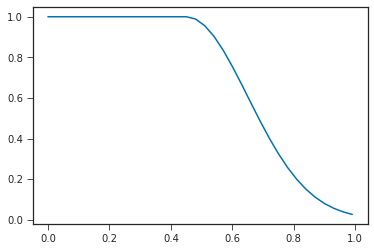

In [114]:
x = np.arange(0, 1, 0.03)
plt.plot(x, gauss_switch(x, 0.2, 0.45))

In [100]:
data_gauss_switch = [gauss_switch(traj, 0.1, 0.45) for traj in data_cz]
ivac_gauss = ivac.LinearIVAC(
    minlag=1, maxlag=3000, nevecs=5, reweight=False, adjust=True, method="fft"
)
ivac_gauss.fit(data_gauss_switch)
data_ivac_gauss = ivac_gauss.transform(data_gauss_switch)

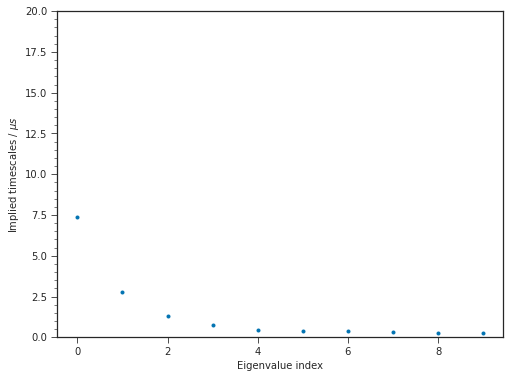

In [101]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac_gauss.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

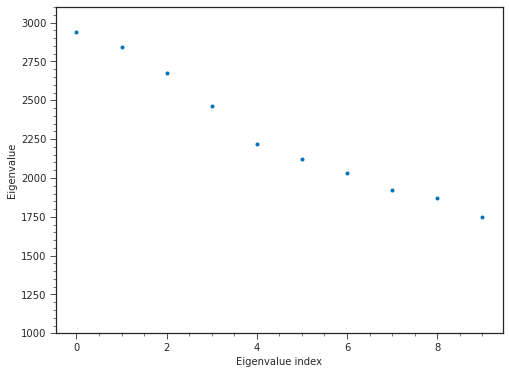

In [102]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac_gauss.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([1000, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

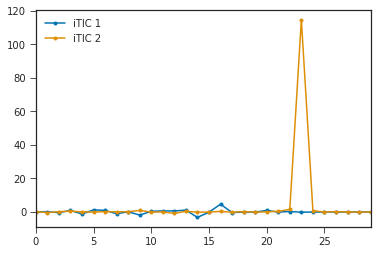

In [104]:
for i in range(1, 3):
    plt.plot(ivac_gauss.evecs[i], ".-", label=f"iTIC {i}")
plt.xlim([0, 29])
plt.legend()

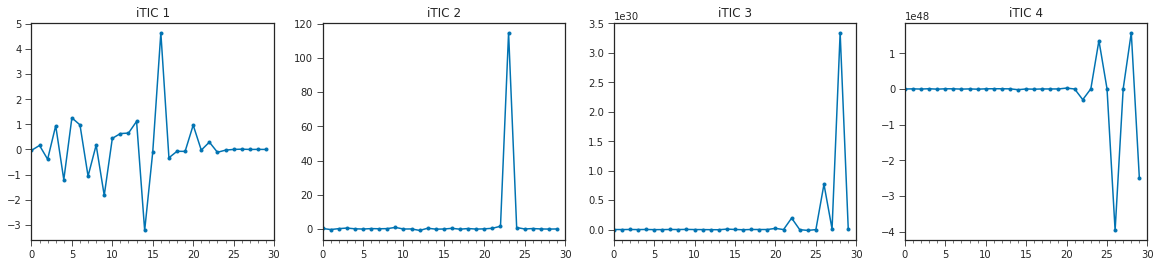

In [105]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.plot(ivac_gauss.evecs[i + 1], ".-")
    ax.set_xlim([0, 30])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_title(f"iTIC {i+1}")

In [106]:
data_gauss_switch[0]

array([[8.51204329e-10, 5.08670462e-04, 1.02160142e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.54349957e-14, 1.13947701e-03, 6.25190233e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.49744887e-11, 6.91657478e-04, 1.20991715e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.80225050e-17, 1.00679137e-01, 1.26974747e-17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.50801886e-21, 5.27263228e-06, 6.00783440e-22, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.10335581e-15, 8.81348178e-02, 1.89948247e-17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float32)

In [108]:
data_ivac_gauss_arr = np.concatenate(data_ivac_gauss)
models_gauss = gauss_switch(models_cz, 0.1, 0.45)
models_ivac = ivac_gauss.transform([models_gauss])[0]

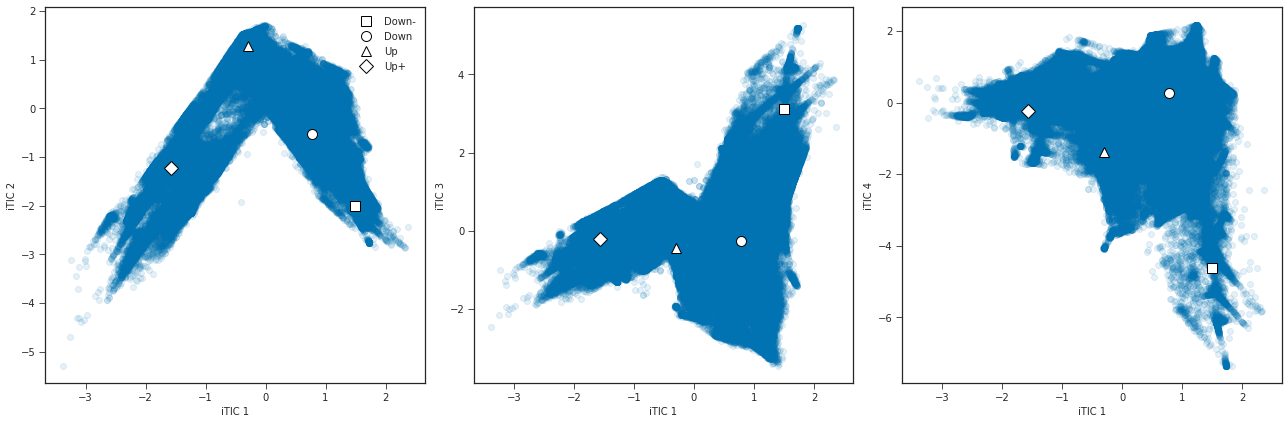

In [109]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        data_ivac_gauss_arr[::10, 1], data_ivac_gauss_arr[::10, i + 2], alpha=0.1
    )
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_ivac[:, 1:3])
util.plot_models(axs[1], models_ivac[:, 1:4:2])
util.plot_models(axs[2], models_ivac[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

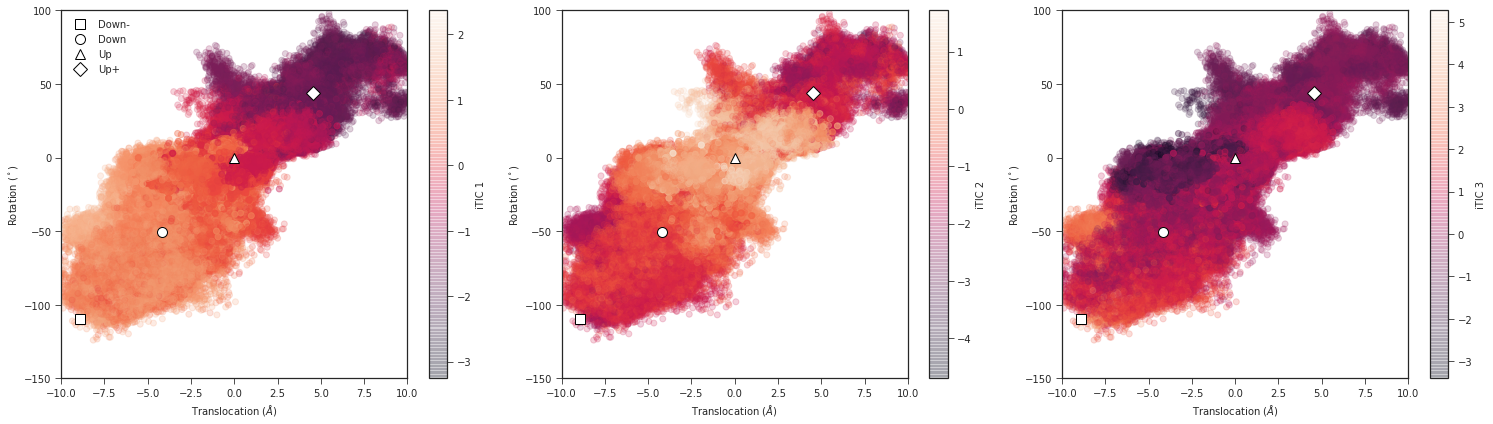

In [110]:
f, axs = plt.subplots(1, 3, figsize=(21, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::20, 0],
        cv_arr[::20, 1],
        c=data_ivac_gauss_arr[::20, i + 1],
        cmap="rocket",
        alpha=0.2,
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel(f"iTIC {i+1}")
    util.format_cvs(ax)
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

Seems like only the first iTIC is useful, as suggested by the harmonics in the previous IVAC calculations

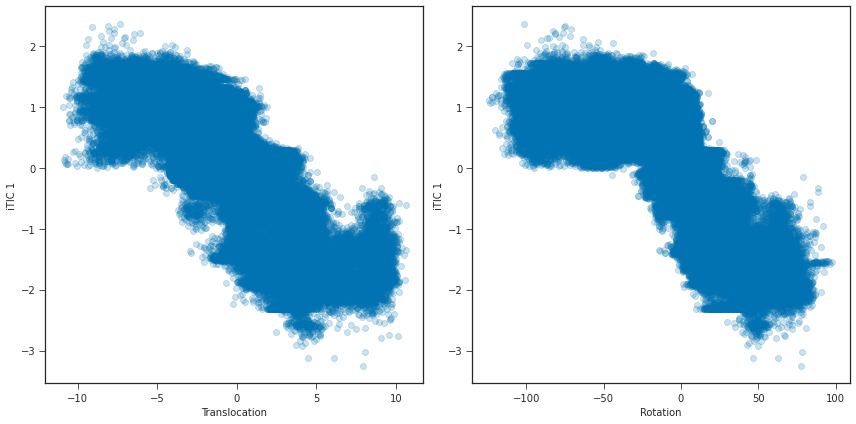

In [112]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(cv_arr[::20, 0], data_ivac_gauss_arr[::20, 1], alpha=0.2)
axs[0].set(xlabel="Translocation", ylabel="iTIC 1")

axs[1].scatter(cv_arr[::20, 1], data_ivac_gauss_arr[::20, 1], alpha=0.2)
axs[1].set(xlabel="Rotation", ylabel="iTIC 1")

f.tight_layout()

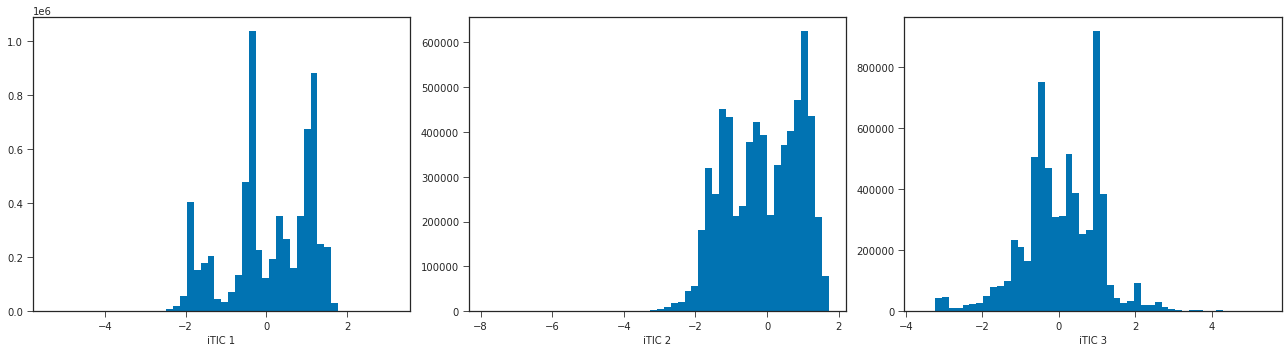

In [113]:
f, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axs):
    ax.hist(data_ivac_gauss_arr[:, i + 1], bins=50)
    ax.set_xlabel(f"iTIC {i+1}")
f.tight_layout()

## Gaussian with different parameters

r0 = 0.2

In [115]:
data_gauss_switch = [gauss_switch(traj, 0.2, 0.45) for traj in data_cz]
ivac_gauss = ivac.LinearIVAC(
    minlag=1, maxlag=3000, nevecs=5, reweight=False, adjust=True, method="fft"
)
ivac_gauss.fit(data_gauss_switch)
data_ivac_gauss = ivac_gauss.transform(data_gauss_switch)

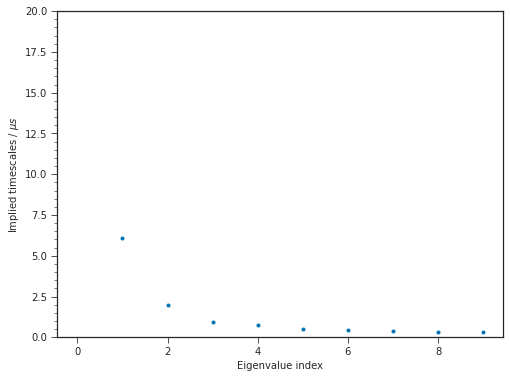

In [116]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac_gauss.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

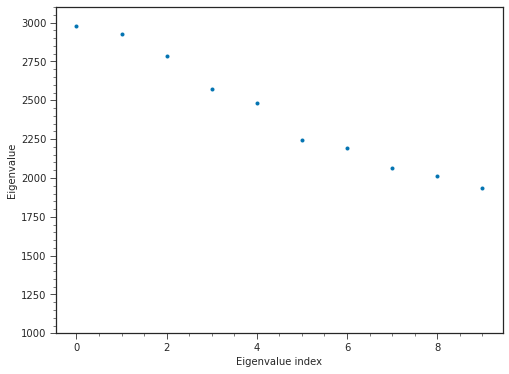

In [117]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac_gauss.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([1000, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

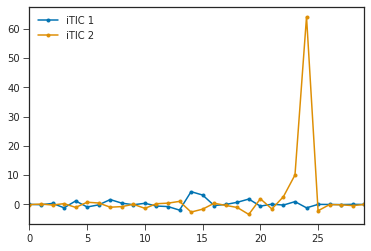

In [118]:
for i in range(1, 3):
    plt.plot(ivac_gauss.evecs[i], ".-", label=f"iTIC {i}")
plt.xlim([0, 29])
plt.legend()

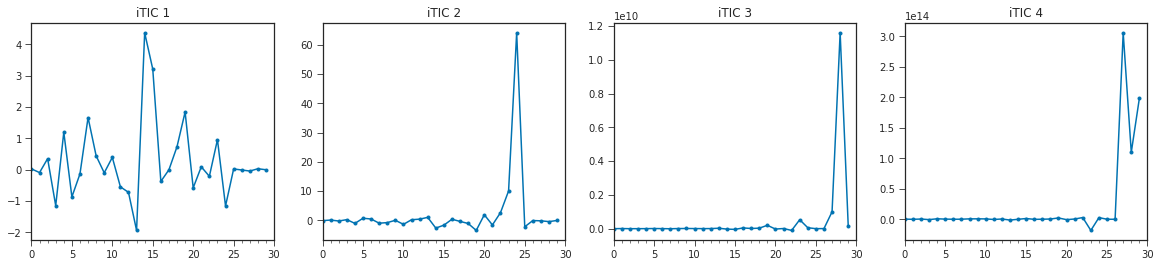

In [119]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.plot(ivac_gauss.evecs[i + 1], ".-")
    ax.set_xlim([0, 30])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_title(f"iTIC {i+1}")

In [120]:
data_gauss_switch[0]

array([[5.4014260e-03, 1.5017897e-01, 1.0053571e-03, ..., 5.7886806e-24,
        1.3906721e-17, 7.9673097e-17],
       [5.4064096e-04, 1.8372843e-01, 2.8119204e-04, ..., 2.3688826e-24,
        4.8194755e-17, 8.8632568e-17],
       [1.9671526e-03, 1.6217084e-01, 1.8650432e-03, ..., 1.4406479e-23,
        1.5129573e-15, 1.0570488e-15],
       ...,
       [7.8525409e-05, 5.6329364e-01, 5.9693815e-05, ..., 1.2218343e-27,
        6.5999153e-18, 3.8327756e-16],
       [7.6960077e-06, 4.7918901e-02, 4.9508471e-06, ..., 3.1220412e-26,
        1.7344735e-17, 1.8811157e-14],
       [2.1415499e-04, 5.4486245e-01, 6.6017456e-05, ..., 3.9868156e-28,
        1.2690551e-17, 3.4682575e-15]], dtype=float32)

In [121]:
data_ivac_gauss_arr = np.concatenate(data_ivac_gauss)
models_gauss = gauss_switch(models_cz, 0.2, 0.45)
models_ivac = ivac_gauss.transform([models_gauss])[0]

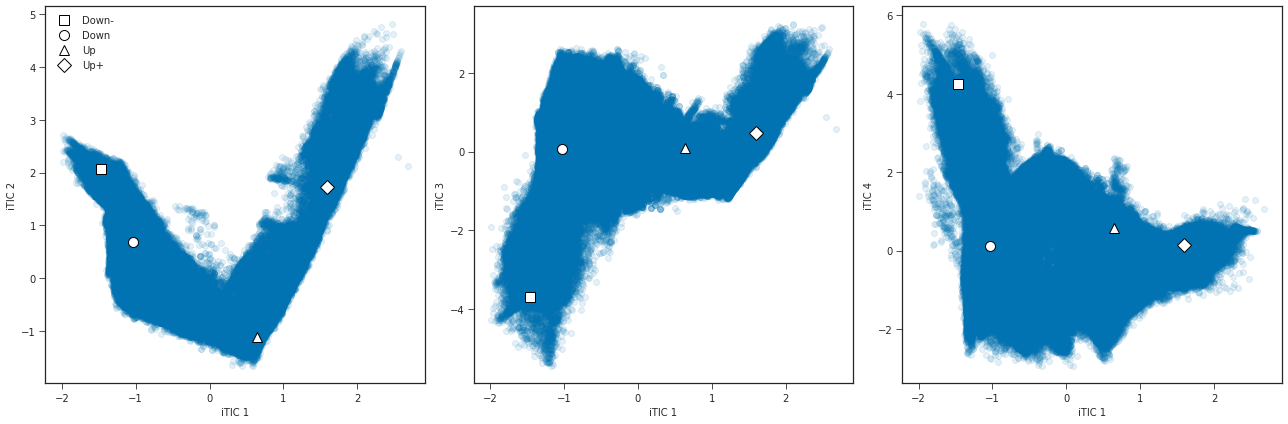

In [122]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        data_ivac_gauss_arr[::10, 1], data_ivac_gauss_arr[::10, i + 2], alpha=0.1
    )
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_ivac[:, 1:3])
util.plot_models(axs[1], models_ivac[:, 1:4:2])
util.plot_models(axs[2], models_ivac[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

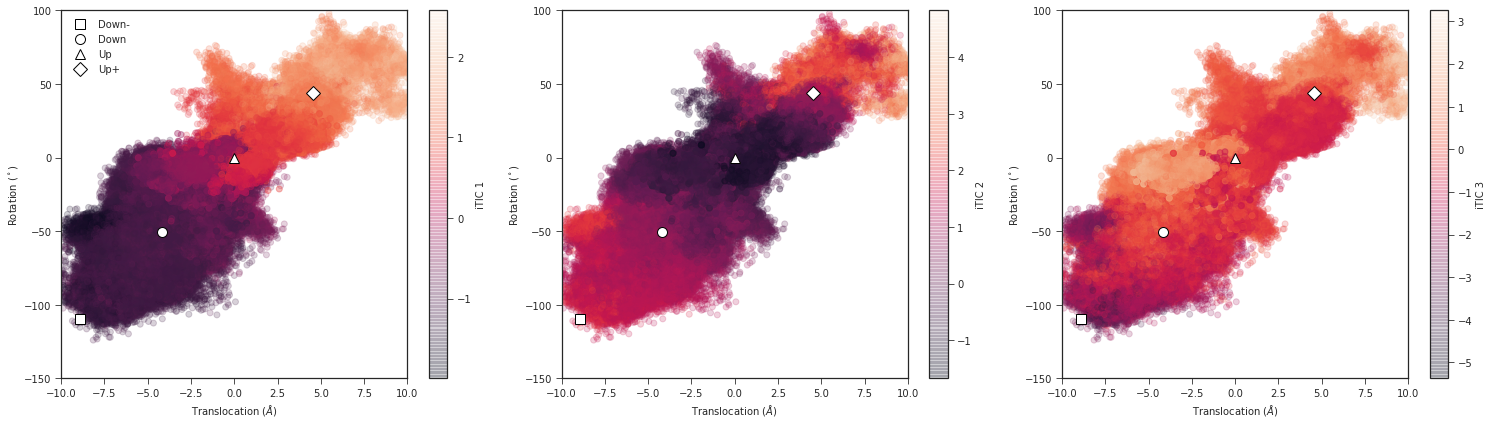

In [123]:
f, axs = plt.subplots(1, 3, figsize=(21, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::20, 0],
        cv_arr[::20, 1],
        c=data_ivac_gauss_arr[::20, i + 1],
        cmap="rocket",
        alpha=0.2,
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel(f"iTIC {i+1}")
    util.format_cvs(ax)
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

Seems like only the first iTIC is useful, as suggested by the harmonics in the previous IVAC calculations

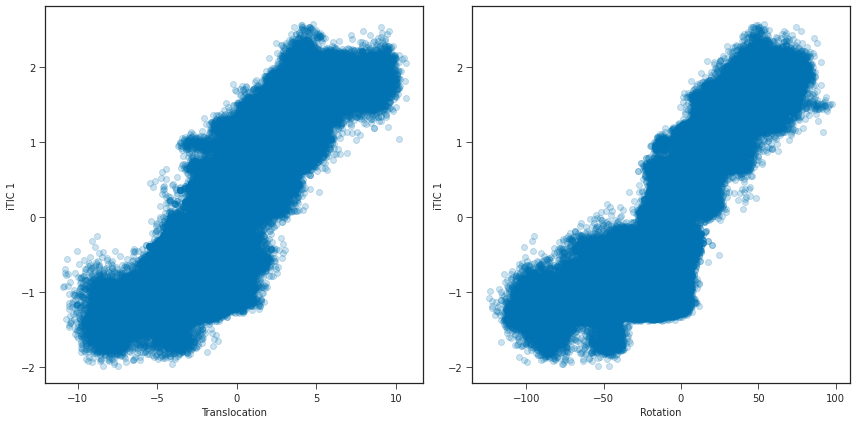

In [124]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(cv_arr[::20, 0], data_ivac_gauss_arr[::20, 1], alpha=0.2)
axs[0].set(xlabel="Translocation", ylabel="iTIC 1")

axs[1].scatter(cv_arr[::20, 1], data_ivac_gauss_arr[::20, 1], alpha=0.2)
axs[1].set(xlabel="Rotation", ylabel="iTIC 1")

f.tight_layout()

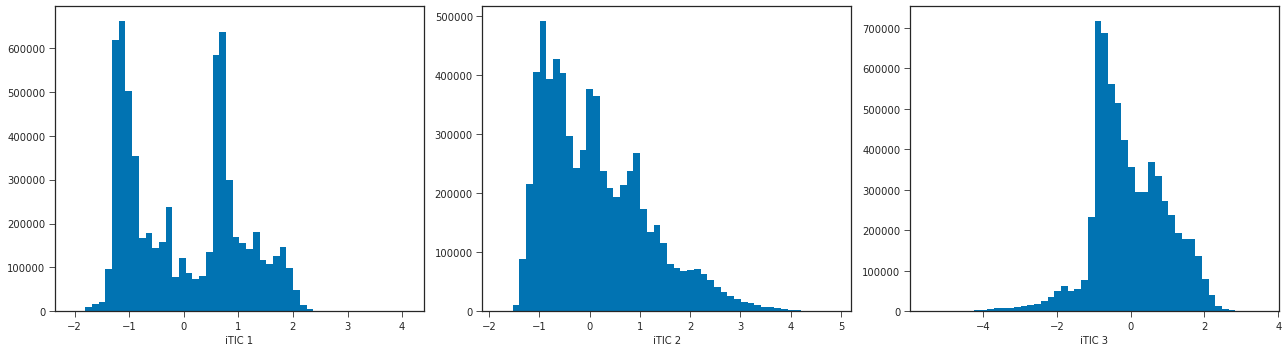

In [125]:
f, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axs):
    ax.hist(data_ivac_gauss_arr[:, i + 1], bins=50)
    ax.set_xlabel(f"iTIC {i+1}")
f.tight_layout()

In [126]:
np.save("../data/sb-livac-gauss.npy", data_ivac_gauss)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [127]:
np.save("../data/models-livac-gauss.npy", models_ivac)

## Transformed ($e^{-d}$) distances 

In [30]:
data_exp = [np.exp(-traj) for traj in data_cz]

In [31]:
ivac_exp = ivac.LinearIVAC(
    minlag=1, maxlag=3000, nevecs=5, reweight=False, adjust=True, method="fft"
)
ivac_exp.fit(data_exp)
data_ivac_exp = ivac_exp.transform(data_exp)

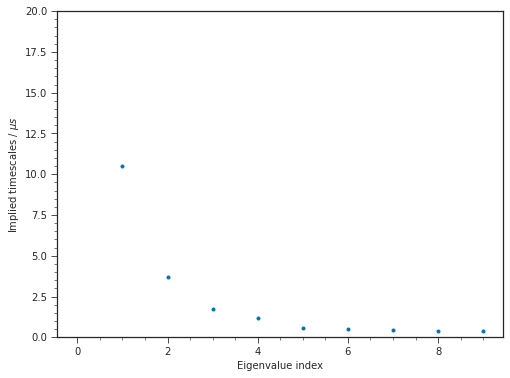

In [33]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac_exp.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

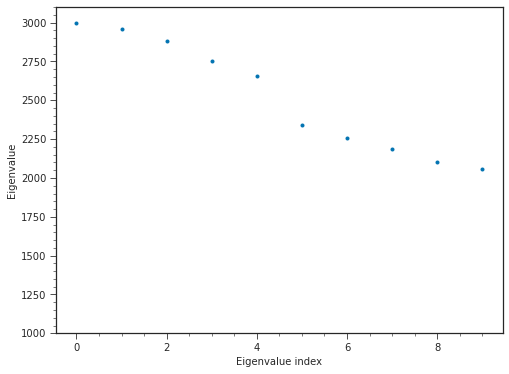

In [35]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(ivac_exp.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([1000, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

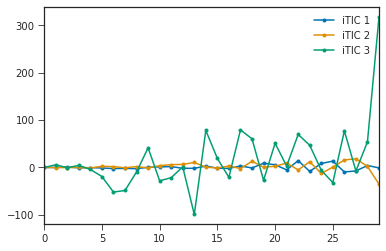

In [38]:
for i in range(1, 4):
    plt.plot(ivac_exp.evecs[i], ".-", label=f"iTIC {i}")
plt.xlim([0, 29])
plt.legend()

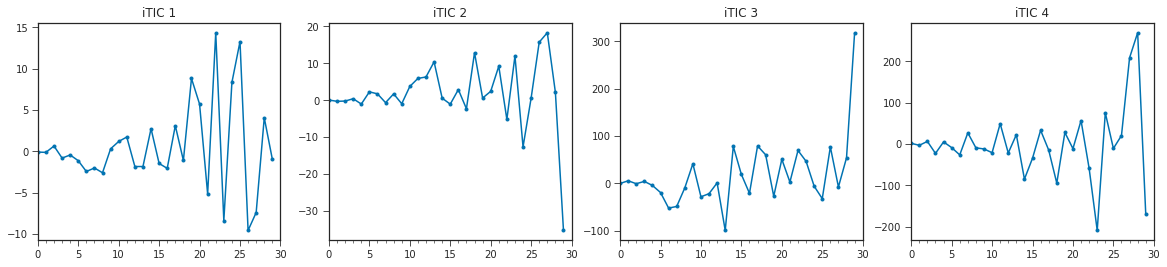

In [40]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.plot(ivac_exp.evecs[i + 1], ".-")
    ax.set_xlim([0, 30])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_title(f"iTIC {i+1}")

In [42]:
data_ivac_exp_arr = np.concatenate(data_ivac_exp)

In [49]:
models_ivac_exp = ivac_exp.transform([np.exp(-models_cz)])
models_ivac_exp = models_ivac_exp[0]
print(models_ivac_exp.shape)

(4, 5)


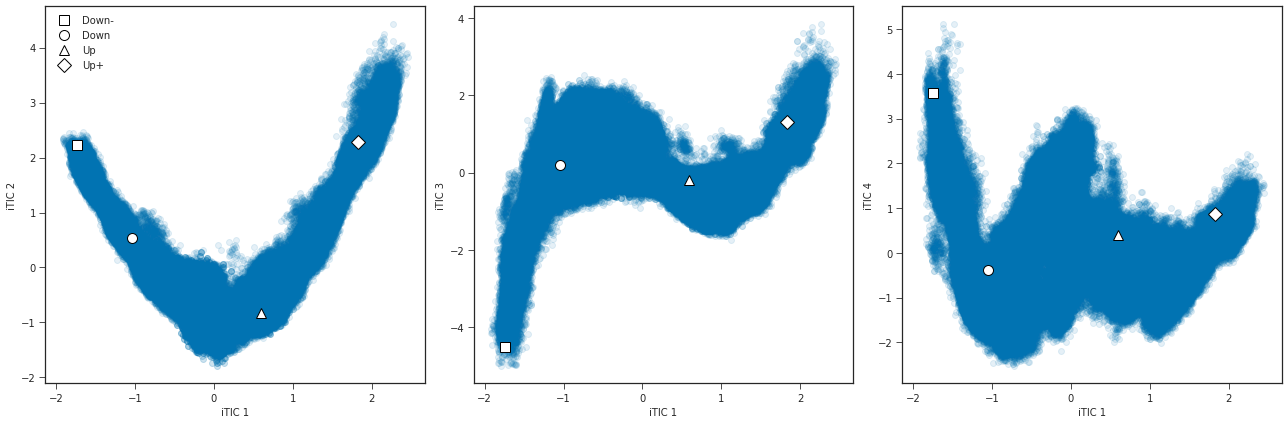

In [53]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        data_ivac_exp_arr[::10, 1], data_ivac_exp_arr[::10, i + 2], alpha=0.1
    )
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_ivac_exp[:, 1:3])
util.plot_models(axs[1], models_ivac_exp[:, 1:4:2])
util.plot_models(axs[2], models_ivac_exp[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

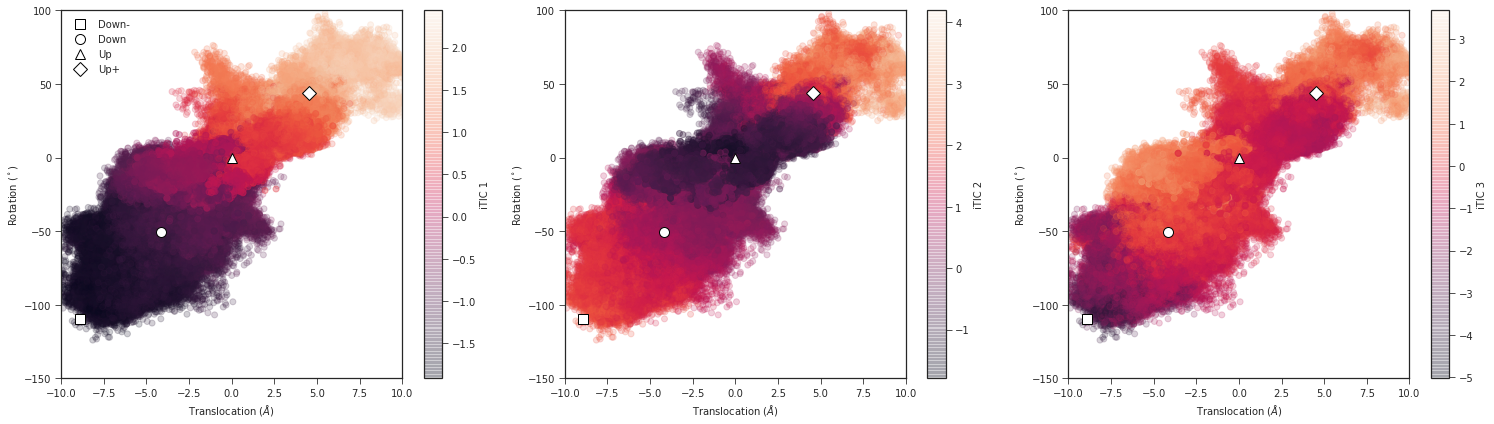

In [54]:
f, axs = plt.subplots(1, 3, figsize=(21, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::20, 0],
        cv_arr[::20, 1],
        c=data_ivac_exp_arr[::20, i + 1],
        cmap="rocket",
        alpha=0.2,
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel(f"iTIC {i+1}")
    util.format_cvs(ax)
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

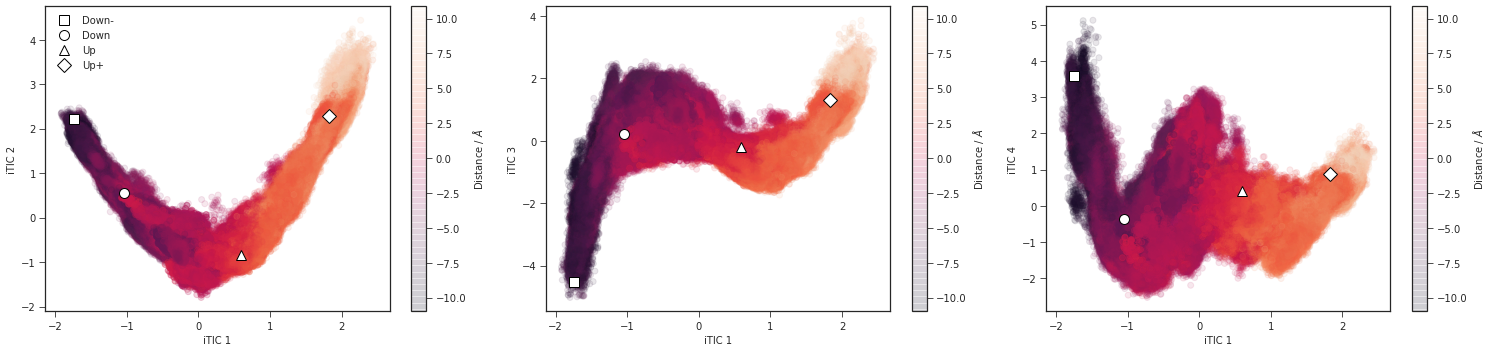

In [55]:
f, axs = plt.subplots(1, 3, figsize=(21, 5))
for i, ax in enumerate(axs):
    h = ax.scatter(
        data_ivac_exp_arr[::10, 1],
        data_ivac_exp_arr[::10, i + 2],
        c=cv_arr[::10, 0],
        cmap="rocket",
        alpha=0.1,
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel("Distance / $\AA$")
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_ivac_exp[:, 1:3])
util.plot_models(axs[1], models_ivac_exp[:, 1:4:2])
util.plot_models(axs[2], models_ivac_exp[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

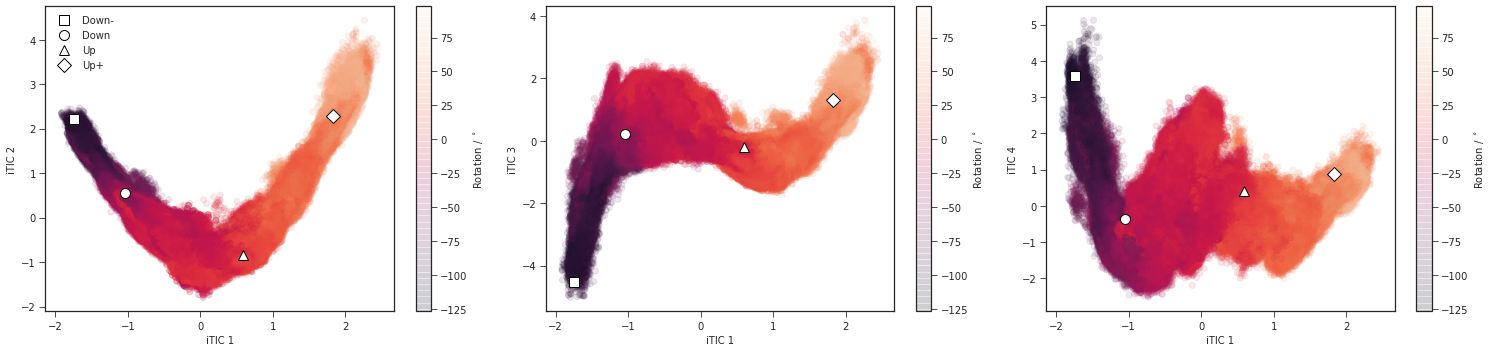

In [56]:
f, axs = plt.subplots(1, 3, figsize=(21, 5))
for i, ax in enumerate(axs):
    h = ax.scatter(
        data_ivac_exp_arr[::10, 1],
        data_ivac_exp_arr[::10, i + 2],
        c=cv_arr[::10, 1],
        cmap="rocket",
        alpha=0.1,
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel("Rotation / $^\circ$")
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_ivac_exp[:, 1:3])
util.plot_models(axs[1], models_ivac_exp[:, 1:4:2])
util.plot_models(axs[2], models_ivac_exp[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

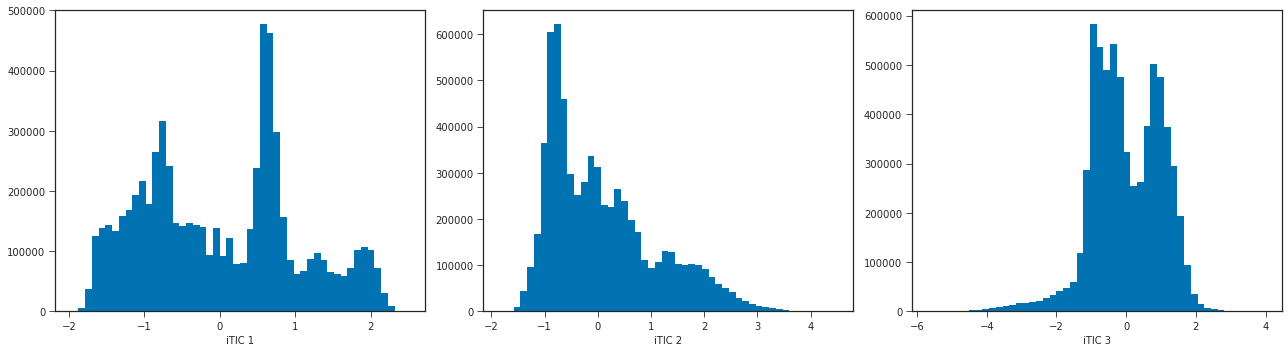

In [57]:
f, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axs):
    ax.hist(data_ivac_exp_arr[:, i + 1], bins=50)
    ax.set_xlabel(f"iTIC {i+1}")
f.tight_layout()